In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

# Data loading

In [2]:
# data path
DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate movies with equal countries are kept
df_movies = cleaning.drop_most_missing(df_movies, ['title', 'countries'])

In [4]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb = cleaning.drop_most_missing(df_tmdb, ['title', 'production_countries'])

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [5]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [6]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [7]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [8]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [9]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [10]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [11]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

With the enrich movie metadata wrangled, the mean ratings for movies are their final attribute to consider. These ratings are retrieved externally, as detailed in the readme. Using the mean ensures any skeweness is a movie's ratings does not influence the movie's measure of a central, representative rating. The ratings provided by the external dataset are supposed to be in 0.5 increments, hence the means pulled from the data must also be by 0.5 increments.

Text(0, 0.5, 'Count of Ratings')

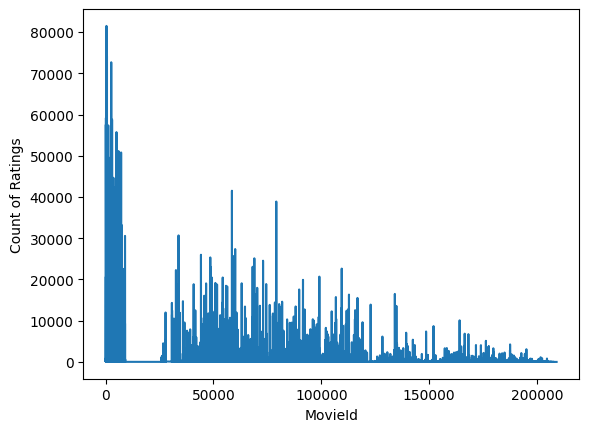

In [12]:
# testing how many ratings each movie has
ratings_distirbution = df_ratings_ratings.groupby("movieId").count()
ratings_distirbution = ratings_distirbution.reset_index()
plt.plot(ratings_distirbution["movieId"], ratings_distirbution["userId"])
plt.xlabel("MovieId")
plt.ylabel("Count of Ratings")

Although each user rates at least 20 movies in the datatset, this doesn't guarantee each movie has the same number of ratings. Also, ratings are on 0.5 scale, yet won't consider as categorical as makes sense to have mean values of ratings that are not 0.5 increments.

In [13]:
# filtering for movies with over 20 ratings
ratings_count = df_ratings_ratings.groupby("movieId")["rating"].count()
movies_with_20_plus_ratings = ratings_count[ratings_count > 20].index
filtered_ratings = df_ratings_ratings[df_ratings_ratings["movieId"].isin(movies_with_20_plus_ratings)].copy()

# taking the mean of each movie's rating
mean_ratings = filtered_ratings.groupby("movieId").mean()

# making the mean of each movie's rating an increment of 0.5
# mean_ratings["rating"] = filtered_ratings["rating"].apply(lambda x: round(x*2)/2)
mean_ratings = mean_ratings.reset_index()

In [14]:
# further cleaning of the ratings dataset is required before merging to the movies metadata
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 11896 unique movies in our movies dataset that have ratings given by the found dataset.


In [15]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [16]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The movie metadata wrangling is considered finished, and baseline visualizations of attributes within help in visualizing their contained data.

The mean number of genres of a given movie is:  5


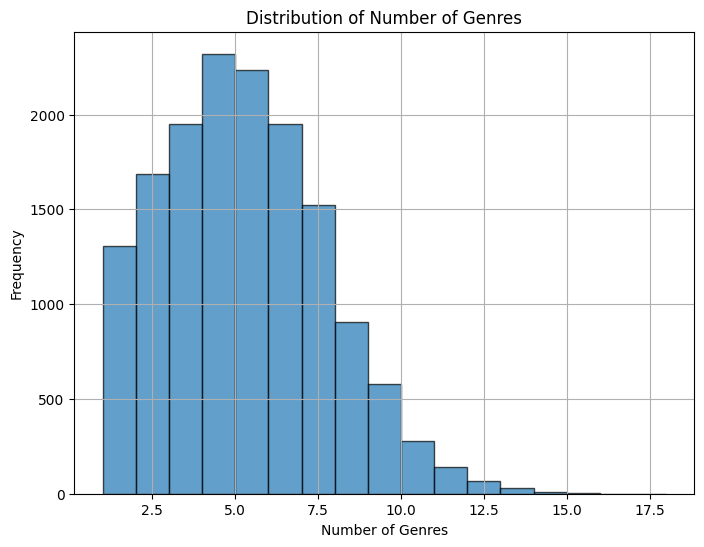

In [17]:
# getting the mean
print(f'The mean number of genres of a given movie is: ', math.ceil(df_movies_tmdb_ratings['genres'].apply(len).mean()))

# plotting the distribution
n_genres = df_movies_tmdb_ratings['genres'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_genres, bins=range(1, max(n_genres) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.grid(True)

In addition, when exploding only some relevant genre-wise movies copies will be kept. For example, if a movie has between genres 'Drama' and 'Acid western', with the first one being way more common than the second in the dataframe, only the movie copy with 'genre' == 'drama' is kept. This allows for a smaller influence of the explode operation on the overall statistics of the datframe, while maintaining a nice standard dataframe structure which is easy to handle genre-wise. 

In [18]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones -> Jake added, below, cleaning of the genres to avoid redundancy
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# making every genre's text uniform to assess unique genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.lower()

# removing redundant verbiage for genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" movies", "")

# fixing some genres being as lists
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].map(str)
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("[", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("]", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("'", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace('"', "")

In [19]:
# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [20]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones -> Jake added further cleaning of genres before choosing the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.lower()

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].map(str)
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("[", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("]", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("'", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace('"', "")

df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# cleaning the single genre movies' genres
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.lower()

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" film", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("[", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("]", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("'", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace('"', "")

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

Now that the genres column has been cleaned, a similar analysis needs to be performed for the 'spoken_languages' one and for 'countries'. Regarding the first one, since the TMDB dataset 'original_language' column has no missing values and has a standard format of one language per movie (e.g. en), this can be used without losing too much information or adding another heavy cleaning code. Considering the 'countries' column, one can follow a similar reasoning as before:

The mean number of countries of a given movie is:  2


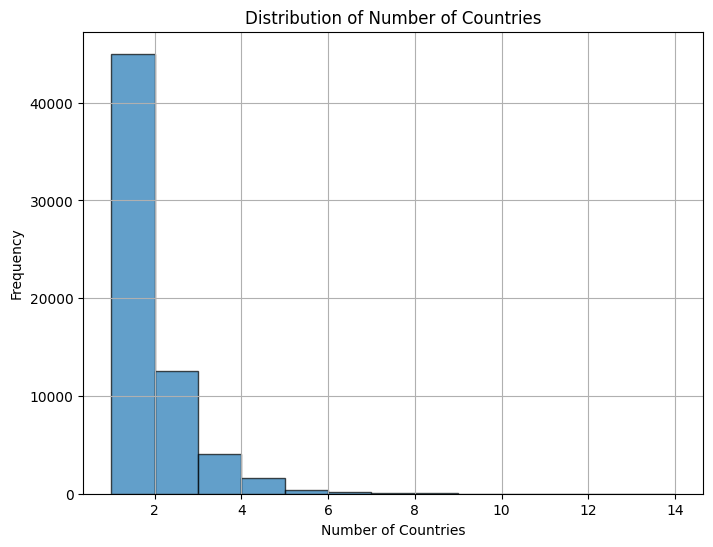

In [21]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

The distribution is heavily left-skewed. Therefore, exploding by countries will not alter the statistics of the dataframe in a too relevant way. Since the number of added entries through exploding is not too large and since one of the main interests of the team's datastory is the geographical analysis of movies, all countries will be kept (i.e. no relevant countries procedure will be applied, opposite to what has been done for genres). Note that, once again, depending on the interested analysis to be performed only one entry for a specific duplicated movie can be easily considered with the current dataframe structure.

In [22]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [23]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [24]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [25]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 11782 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


In [26]:
# deleting not used dataframes (but keeping the original ones)
del df_movies_tmdb
del df_movies_tmdb_ratings_exploded
del df_movies_tmdb_ratings_multi
del df_ratings_linked

### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [27]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

## Defining a master movies dataset
`df_movies_tmdb_ratings` is now one of the master dataframes. Since two columns have been exploded (`genres`, `revenues`) statistics might have been altered. Therefore, a smaller dataframe containing only unique titles must be defined to analyze features such as `revenue` or the ratings-related ones. Unique titles rows with the smallest amount of missing values among columns will be selected. This final master dataframe is `df_movies_tmdb_ratings_unique`.

In [28]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

In [29]:
df_movies_tmdb_ratings_unique.head()

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,spoken_languages,countries,genres,budget,imdb_id,original_language,production_companies,mean_rating,mean_rating_timestamp,region
1309,4213160,/m/0bq8q8,$,1971,NaN,119.0,[English Language],United States of America,crime fiction,None,68152,en,"Worldwide, Pan, Columbia Pictures",3.000000,1.382590e+09,North America
1314,20624798,/m/05222ld,$9.99,2008,NaN,78.0,[English Language],Israel,drama,None,790799,en,"Lama Films, Australian Film Finance Corporatio...",3.125000,1.364048e+09,North Africa and Middle East
1318,3610422,/m/09pt2f,'Neath the Arizona Skies,1934,NaN,52.0,[English Language],United States of America,action/adventure,None,24805,en,"Monogram Pictures, Lone Star",2.238095,1.325392e+09,North America
1326,24799628,/m/080nt72,'R Xmas,2001,NaN,83.0,"[English Language, Spanish Language]",United States of America,indie,None,217978,en,Barnholtz Entertainment,2.574074,1.373471e+09,North America
1327,20586022,/m/051wj3s,'Twas the Night Before Christmas,1974,NaN,60.0,None,United States of America,family,None,208654,en,Rankin/Bass Productions,3.437500,1.464166e+09,North America


# Integrating the Characters DataFrame

In [30]:
#Translated everything on query.wikidata.org and printed them on .csv files 
query = './src/data/query/'
csv_files = [query + file for file in os.listdir(query) if file.endswith('.csv')]
label_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
label_df.columns = ["freebase_id","wikipedia_id" ,"label"]  
freebase_to_label = dict(zip(label_df["freebase_id"], label_df["label"]))

#Creating ethnicity label column where we map the freebse ethnicity Id to the label
df_characters["ethnicity_label"] = df_characters["actor_ethnicity"].map(freebase_to_label)
print(df_characters[["actor_ethnicity", "ethnicity_label"]].head()) 

  actor_ethnicity    ethnicity_label
0             NaN                NaN
1      /m/044038p                NaN
2         /m/0x67  African Americans
3             NaN                NaN
4             NaN                NaN


In [31]:
# Get the counts of unique values in 'ethnicity_label', including NaN
ethnicity_counts = df_characters['ethnicity_label'].value_counts(dropna=False)

# Display all unique values in 'ethnicity_label' without truncation
pd.set_option('display.max_rows', None)  # Display all rows without truncation
print("Unique values in 'ethnicity_label' and their counts:")
print(ethnicity_counts)
pd.reset_option('display.max_rows') 

Unique values in 'ethnicity_label' and their counts:
ethnicity_label
NaN                                       347766
Indians                                    16351
African Americans                          10159
Jewish people                              10121
English people                              6165
Irish Americans                             3857
Italian Americans                           2956
White people                                2307
White Americans                             2250
Scottish Americans                          2223
Irish people                                1637
British                                     1433
French                                      1350
Italians                                    1305
Tamil                                       1215
Punjabis                                    1155
Malayali                                    1146
Scottish people                             1028
Swedish Americans                            977


### Clustering Ethnicities & Adding Nationalities & Ethnicities from Wikidata:

In [32]:
# Load the dictionary from the .txt file
with open(DATA +"ethnicities_clusters.txt", "r") as file:
    ethnicities = ast.literal_eval(file.read())

In [33]:
# Map each actor's ethnicity to ALL clusters it belongs to
ethnicity_to_clusters = {}
for cluster, labels in ethnicities.items():
    for label in labels:
        ethnicity_to_clusters.setdefault(label, []).append(cluster)

# We control duplicates as well because the clusters were done manually 
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(ethnicity_to_clusters.get(ethnicity, [])))
)

In [34]:
df_wikidata = pd.read_csv('wikidata_actor_info.csv', sep=',', header=None, names=['freebaseID', 'actorLabel' , 'ethnicityLabel' , 'nationalityLabel'])

In [35]:
#unmatched/ambiguous ethnicities
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].apply(lambda x: isinstance(x, list) and len(x) == 0)]['ethnicity_label'].unique()
#merging wikidata with df_characters
df_merged = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

def fill_ethnicity(row):
    if row['ethnicity_label'] in unmatched_ethnicities:
        # If the ethnicity is ambiguous, retrieve the nationality
        return row['nationalityLabel'] if pd.notna(row['nationalityLabel']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['ethnicity_label'])
    else:
        # For non-ambiguous cases, retrieve the ethnicity label associated to it or fallback to nationality
        return row['ethnicity_label'] if pd.notna(row['ethnicity_label']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['nationalityLabel']
        )

df_merged['ethnicity_label'] = df_merged.apply(fill_ethnicity, axis=1)

In [36]:
#drop some unnecessary columns
df_merged.drop(columns=["freebase_id", "character_name", "actor_birth", "actor_height", "freebase_map","actor_ethnicity" ,"freebaseID","actorLabel", "nationalityLabel"], inplace=True)
df_merged.head() 

,wikipedia_id,release_date,actor_gender,actor_name,age_at_release,freebase_character_id,freebase_actor_id,ethnicity_label,mapped_clusters,ethnicityLabel
0,975900,2001-08-24,F,Wanda De Jesus,42.0,/m/0bgcj3x,/m/03wcfv7,United States of America,[],NaN
1,975900,2001-08-24,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4,Canada,[],NaN
2,975900,2001-08-24,M,Ice Cube,32.0,/m/0bgchn_,/m/01vw26l,African Americans,"[South and Central African, North Americans]",NaN
3,975900,2001-08-24,M,Jason Statham,33.0,/m/0bgchnq,/m/034hyc,United Kingdom,[],NaN
4,975900,2001-08-24,F,Clea DuVall,23.0,/m/0bgchp9,/m/01y9xg,United States of America,[],NaN


In [37]:
#mapping the new ethnicities to our clusters (the clusters.txt have been modified for this step)
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities.items():
    for label in labels:
        new_ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_merged['mapped_clusters'] = df_merged['ethnicity_label'].apply(
    lambda ethnicity: list(set(new_ethnicity_to_clusters.get(ethnicity, [])))
)

In [38]:
# Identify unmatched ethnicity labels
unmatched_ethnicities = df_merged[df_merged['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# Count occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# Print the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# Print unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
Jewish people              3504
multiracial people            4
Q25589681                     4
Karay-a people                2
مسح                           1
peoples of the Caucasus       1
Name: count, dtype: int64


- This is the minimum of ambiguous ethnicities we could have. Those will remain inclassified since our analysis focuses on regions. 

In [39]:
df_merged.drop(columns=["freebase_character_id" ,"ethnicityLabel" ,"actor_name" ,"age_at_release" ], inplace=True)

df_merged.columns

Index(['wikipedia_id', 'release_date', 'actor_gender', 'freebase_actor_id',
       'ethnicity_label', 'mapped_clusters'],
      dtype='object')

In [40]:
#merging based on wikipedia ID
df_movies_tmdb_ratings_characters = pd.merge(df_merged[['wikipedia_id','actor_gender','ethnicity_label','mapped_clusters','freebase_actor_id']],
                             df_movies_tmdb_ratings_unique[['wikipedia_id','countries', 'title', 'release_date','genres','mean_rating','mean_rating_timestamp','region']
                                       ], 
                             on='wikipedia_id', how='inner')

df_movies_tmdb_ratings_characters.columns

Index(['wikipedia_id', 'actor_gender', 'ethnicity_label', 'mapped_clusters',
       'freebase_actor_id', 'countries', 'title', 'release_date', 'genres',
       'mean_rating', 'mean_rating_timestamp', 'region'],
      dtype='object')

In [41]:
df_movies_tmdb_ratings_characters = df_movies_tmdb_ratings_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})

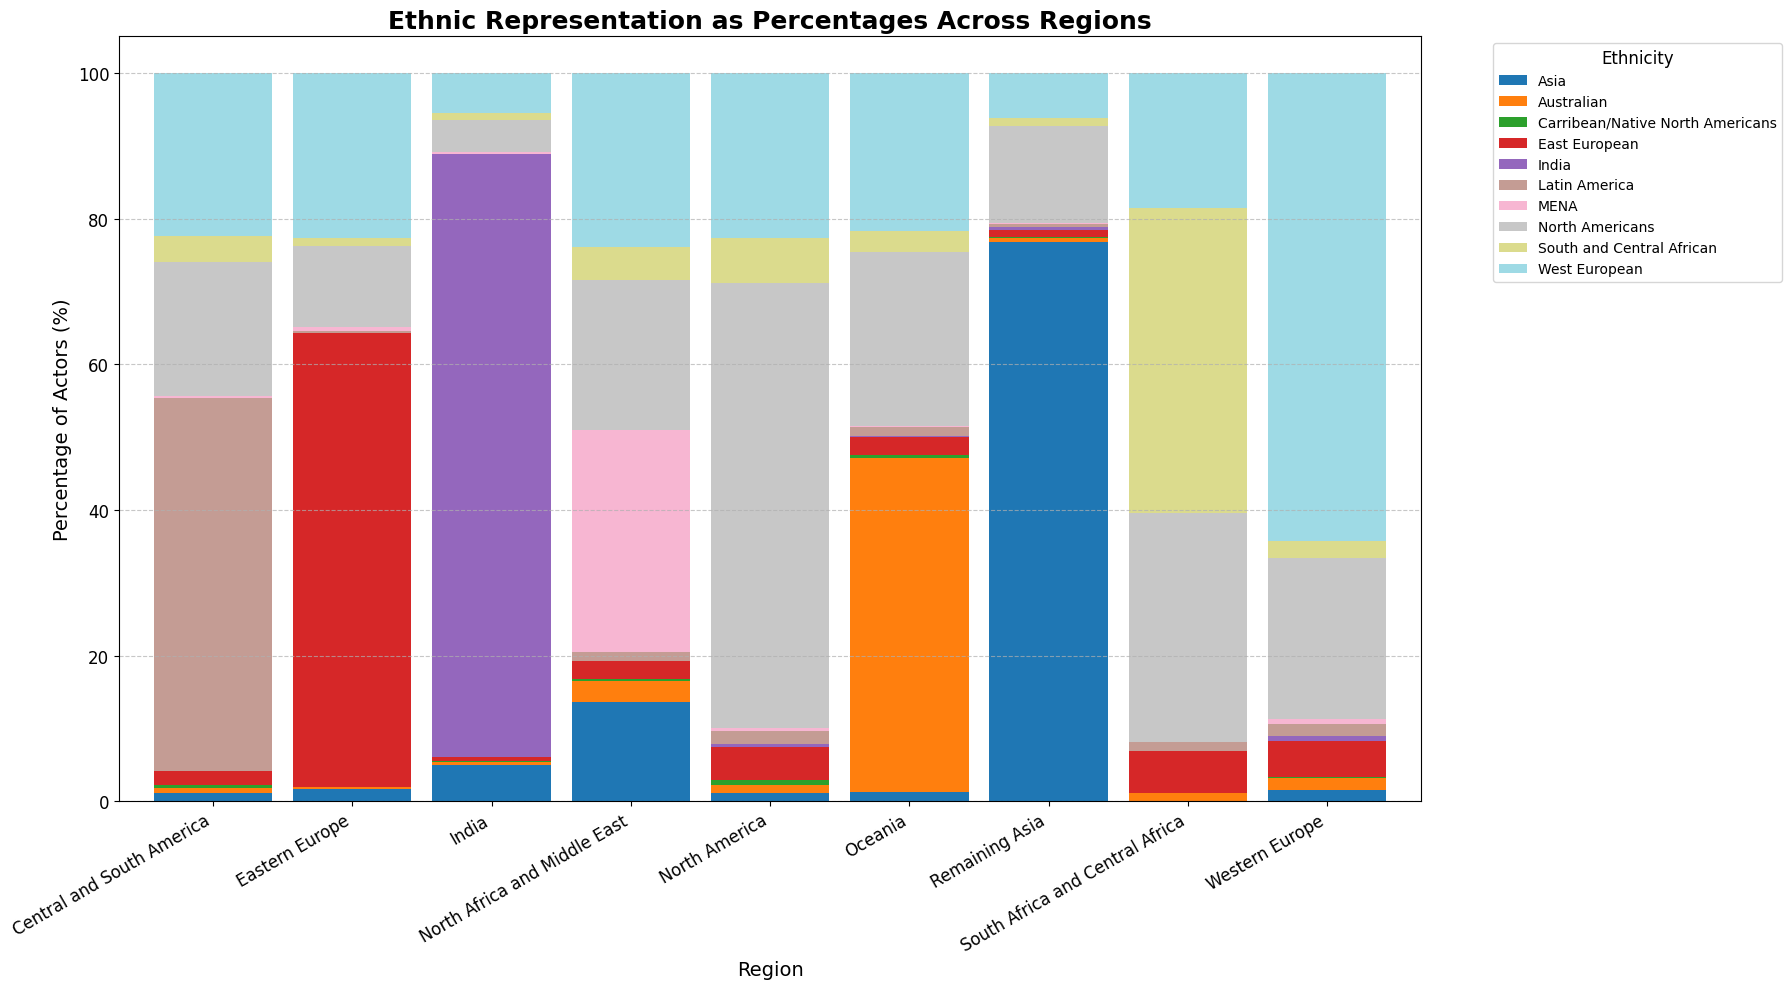

In [42]:
# Filter rows where both 'regions' and 'mapped_clusters' are not NaN
df_characters_region_ethnicity = df_movies_tmdb_ratings_characters.dropna(subset=['region', 'actor_ethnicity'])

# Explode the 'mapped_clusters' column to handle lists
df_characters_region_ethnicity_exploded = df_characters_region_ethnicity.explode('actor_ethnicity')

# Ethnicity representation by region
region_ethnicity_trends = df_characters_region_ethnicity_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# Calculate percentages for each region
region_ethnicity_percent = region_ethnicity_trends.div(region_ethnicity_trends.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(18, 10))  # Larger figure size for readability
region_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


In [43]:
df_movies_tmdb_ratings_characters[['region', 'actor_ethnicity']].head(20)


,region,actor_ethnicity
0,North America,[North Americans]
1,North America,[North Americans]
2,North America,"[South and Central African, North Americans]"
3,North America,[West European]
4,North America,[North Americans]
5,North America,"[South and Central African, North Americans]"
6,North America,[North Americans]
7,North America,[]
8,North America,[North Americans]
9,North America,[North Americans]


What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




## 1-Ethnicity Score 

First we create a new dataframe which will contain the movie_id , number of characters of each movie , and proportion of individuals of each ethnicity in each movie, and finally the SDI ethnicity score for each movie. 

## IMPORTANT: DO I KEEP THE COVERAGE PER MOVIE THING AND DO PROPORTIONS BASED ON ACTORS WHO HAVE AVAILABLE ETHNICITIES ONLY OR DO I KEEP IT SIMPLE LIKE THIS ? 

In [44]:
df_movies_tmdb_ratings_characters.columns


Index(['wikipedia_id', 'actor_gender', 'ethnicity_label', 'actor_ethnicity',
       'freebase_actor_id', 'countries', 'title', 'release_date', 'genres',
       'mean_rating', 'mean_rating_timestamp', 'region'],
      dtype='object')

In [45]:
#New dataframe for Ethnicity and Gender diversity scores
df_actor_stats = df_movies_tmdb_ratings_characters[['actor_ethnicity', 'wikipedia_id', 'freebase_actor_id','actor_gender']].copy()
df_actor_stats.shape


(137723, 4)

In [46]:
#Df for ethnicity diversity score
df_ethnicity_exploded = df_actor_stats.explode('actor_ethnicity')
df_ethnicity_exploded.shape



(159146, 4)

In [48]:
df_ethnicity_exploded = df_ethnicity_exploded.dropna(subset=['actor_ethnicity'])
df_ethnicity_exploded.shape

(110805, 4)

In [50]:
# Occurrences of each ethnicity per movie
ethnicity_counts = df_ethnicity_exploded.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')

# Total number of actors per movie
total_actors = df_ethnicity_exploded.groupby('wikipedia_id').size().reset_index(name='total_actors')

# Merge counts back into exploded dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')

# Proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']

df_ethnicity_counts.head(20) 


,wikipedia_id,actor_ethnicity,ethnicity_count,total_actors,ethnicity_proportion
0,3217,East European,1,13,0.076923
1,3217,North Americans,9,13,0.692308
2,3217,West European,3,13,0.230769
3,3333,North Americans,12,14,0.857143
4,3333,West European,2,14,0.142857
5,3746,Asia,1,12,0.083333
6,3746,Latin America,1,12,0.083333
7,3746,North Americans,8,12,0.666667
8,3746,West European,2,12,0.166667
9,3837,East European,2,21,0.095238


In [51]:
def shannon_entropy(proportions):
    """
    Calculates the Shannon entropy given a list or series of proportions.
    
    Parameters:
    proportions (list or pd.Series): Proportions of categories in a group.
    
    Returns:
    float: Shannon entropy (diversity index).
    """
    return -np.sum(proportions * np.log(proportions))

# Calculate SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# Merge the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

df_ethnicity_counts.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_22916/1782343307.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_ethnicity,ethnicity_count,total_actors,ethnicity_proportion,SDI_ethnicity
0,3217,East European,1,13,0.076923,0.790268
1,3217,North Americans,9,13,0.692308,0.790268
2,3217,West European,3,13,0.230769,0.790268
3,3333,North Americans,12,14,0.857143,0.410116
4,3333,West European,2,14,0.142857,0.410116


In [52]:
df_ethnicity_counts["SDI_ethnicity"].describe()

count    29035.000000
mean         0.826170
std          0.375588
min         -0.000000
25%          0.636514
50%          0.885574
75%          1.088900
max          1.812001
Name: SDI_ethnicity, dtype: float64

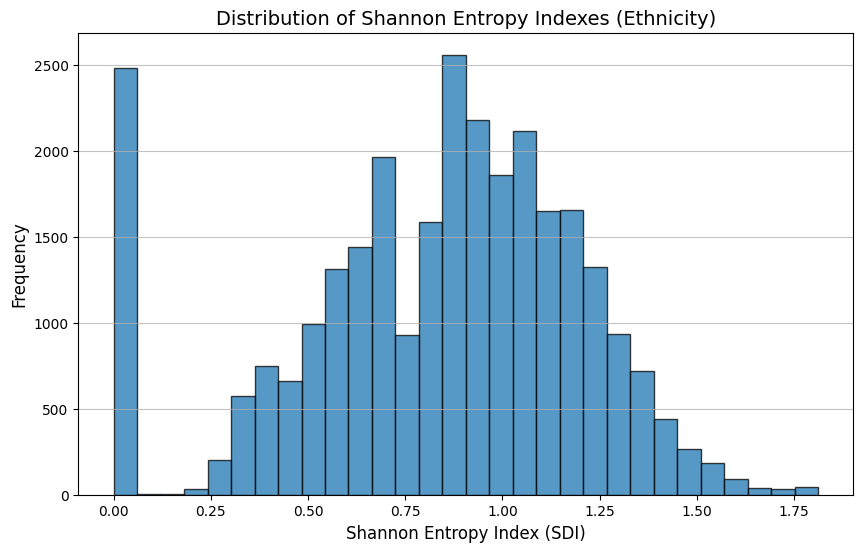

In [53]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The curve resembles a normal distribution, with most movies having moderate diversity (SDI around 0.8) and fewer movies at the extremes (low or high diversity).

High values = High diversity and balanced distribution of the ethnicities of the cast, no dominance of one ethnicity over the others. 
Lower value = No diversity / All cast members have the same one ethnicity. 

## 1-Gender Score 

In [54]:
df_actor_stats.shape

(137723, 4)

In [55]:
df_actor_stats = df_actor_stats.dropna(subset=['actor_gender'])

df_actor_stats.shape

(126051, 4)

In [56]:
# For Gender Diversity Index (SDI)
# Ooccurrences of each gender per movie
gender_counts = df_actor_stats.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')
# Total number of actors per movie
total_actors_per_movie = df_actor_stats.groupby('wikipedia_id').size().reset_index(name='total_actors')
#Merge the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors_per_movie, on='wikipedia_id')
# Proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

# Step 5: Calculate SDI for each movie
df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# Merge the SDI scores back
df_gender_counts = df_gender_counts.merge(df_sdi_gender, on='wikipedia_id')

df_gender_counts.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_22916/1217614420.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_gender,gender_count,total_actors,gender_proportion,SDI_gender
0,3217,F,3,13,0.230769,0.540204
1,3217,M,10,13,0.769231,0.540204
2,3333,F,6,15,0.400000,0.673012
3,3333,M,9,15,0.600000,0.673012
4,3746,F,3,14,0.214286,0.519580


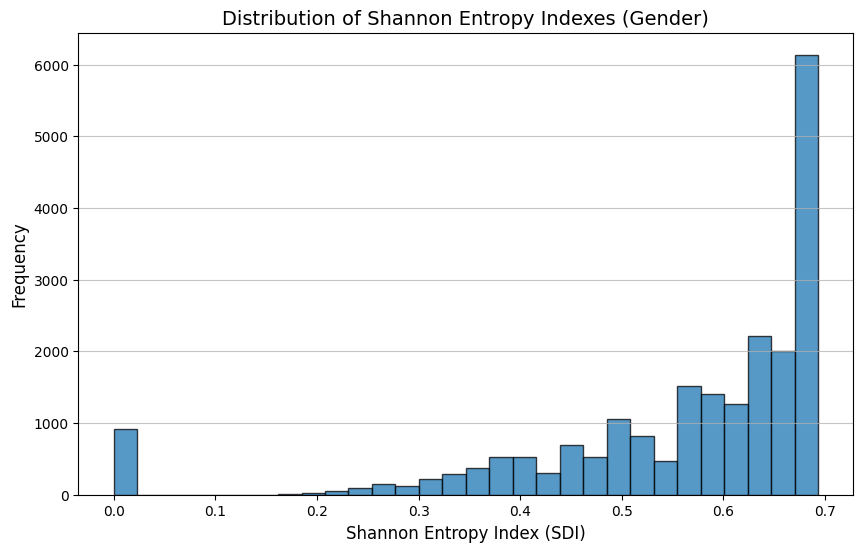

In [57]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Here, many films cluster around a moderate to relatively high SDI (around 0.6–0.7), suggesting that a substantial portion have a fairly mixed gender distribution, while a noticeable subset score near zero, indicating casts composed of only one gender.

## Now back to the original data frame: 

In [58]:
df_movies_tmdb_ratings_characters = df_movies_tmdb_ratings_characters.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']].drop_duplicates(),
    on='wikipedia_id',
    how='left'
)

df_movies_tmdb_ratings_characters = df_movies_tmdb_ratings_characters.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']].drop_duplicates(),
    on='wikipedia_id',
    how='left'
)

In [59]:
df_movies_tmdb_ratings_characters.head()

,wikipedia_id,actor_gender,ethnicity_label,actor_ethnicity,freebase_actor_id,countries,title,release_date,genres,mean_rating,mean_rating_timestamp,region,SDI_ethnicity,SDI_gender
0,975900,F,United States of America,[North Americans],/m/03wcfv7,United States of America,Ghosts of Mars,2001,action,2.34227,1.195518e+09,North America,0.895333,0.649248
1,975900,F,Canada,[North Americans],/m/0346l4,United States of America,Ghosts of Mars,2001,action,2.34227,1.195518e+09,North America,0.895333,0.649248
2,975900,M,African Americans,"[South and Central African, North Americans]",/m/01vw26l,United States of America,Ghosts of Mars,2001,action,2.34227,1.195518e+09,North America,0.895333,0.649248
3,975900,M,United Kingdom,[West European],/m/034hyc,United States of America,Ghosts of Mars,2001,action,2.34227,1.195518e+09,North America,0.895333,0.649248
4,975900,F,United States of America,[North Americans],/m/01y9xg,United States of America,Ghosts of Mars,2001,action,2.34227,1.195518e+09,North America,0.895333,0.649248


In [60]:
df_correlation_ethnicity = df_movies_tmdb_ratings_characters[['mean_rating', 'SDI_ethnicity']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_ethnicity['mean_rating'], df_correlation_ethnicity['SDI_ethnicity'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_ethnicity['mean_rating'], df_correlation_ethnicity['SDI_ethnicity'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: -0.1632, p-value: 0.0000
Spearman correlation: -0.1703, p-value: 0.0000


Statistical significance but very mow values. 

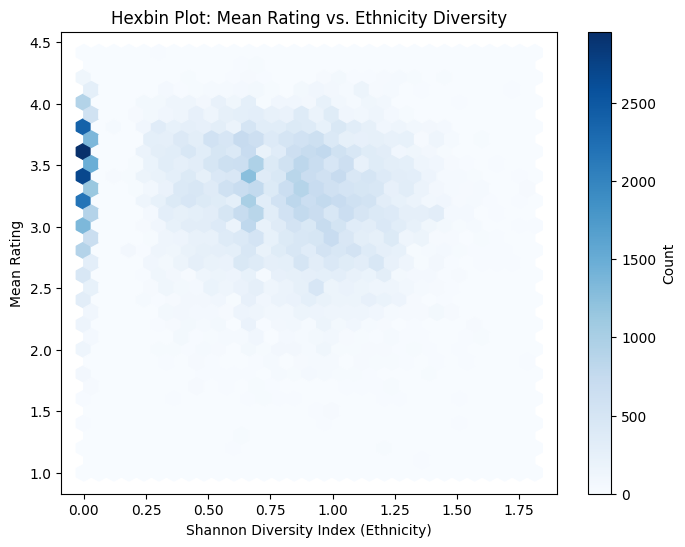

In [61]:
plt.figure(figsize=(8,6))
plt.hexbin(df_correlation_ethnicity['SDI_ethnicity'], 
           df_correlation_ethnicity['mean_rating'], 
           gridsize=30, 
           cmap='Blues')
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Hexbin Plot: Mean Rating vs. Ethnicity Diversity')
plt.colorbar(label='Count')
plt.show()


In [62]:
""" import seaborn as sns
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=df_correlation_ethnicity['SDI_ethnicity'], 
    y=df_correlation_ethnicity['mean_rating'], 
    fill=True, levels=50, cmap='viridis'
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('KDE Contour Plot: Mean Rating vs. Ethnicity Diversity')
plt.show() """


" import seaborn as sns\nplt.figure(figsize=(8,6))\nsns.kdeplot(\n    x=df_correlation_ethnicity['SDI_ethnicity'], \n    y=df_correlation_ethnicity['mean_rating'], \n    fill=True, levels=50, cmap='viridis'\n)\nplt.xlabel('Shannon Diversity Index (Ethnicity)')\nplt.ylabel('Mean Rating')\nplt.title('KDE Contour Plot: Mean Rating vs. Ethnicity Diversity')\nplt.show() "

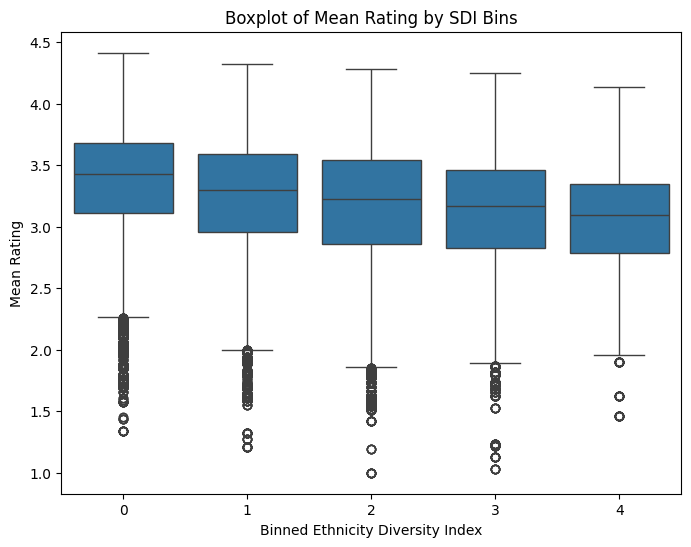

In [63]:
# Example: create bins for SDI_ethnicity
df_binned = df_correlation_ethnicity.copy()
df_binned['SDI_bin'] = pd.cut(df_binned['SDI_ethnicity'], bins=5, labels=False)

plt.figure(figsize=(8,6))
sns.boxplot(x='SDI_bin', y='mean_rating', data=df_binned)
plt.xlabel('Binned Ethnicity Diversity Index')
plt.ylabel('Mean Rating')
plt.title('Boxplot of Mean Rating by SDI Bins')
plt.show()


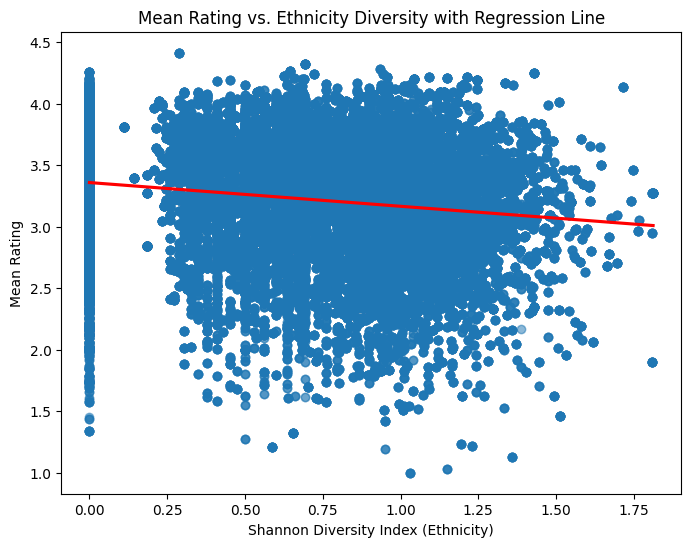

In [64]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_ethnicity', 
    y='mean_rating', 
    data=df_correlation_ethnicity, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Ethnicity Diversity with Regression Line')
plt.show()


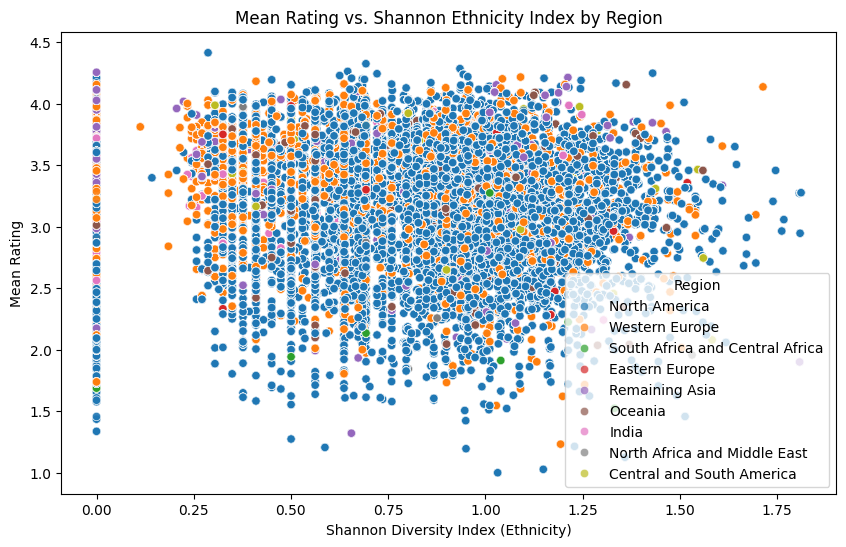

In [71]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_movies_tmdb_ratings_characters,
    x='SDI_ethnicity', 
    y='mean_rating', 
    hue='region',
    alpha=0.7
)

plt.title('Mean Rating vs. Shannon Ethnicity Index by Region')
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.legend(title='Region')
plt.show()


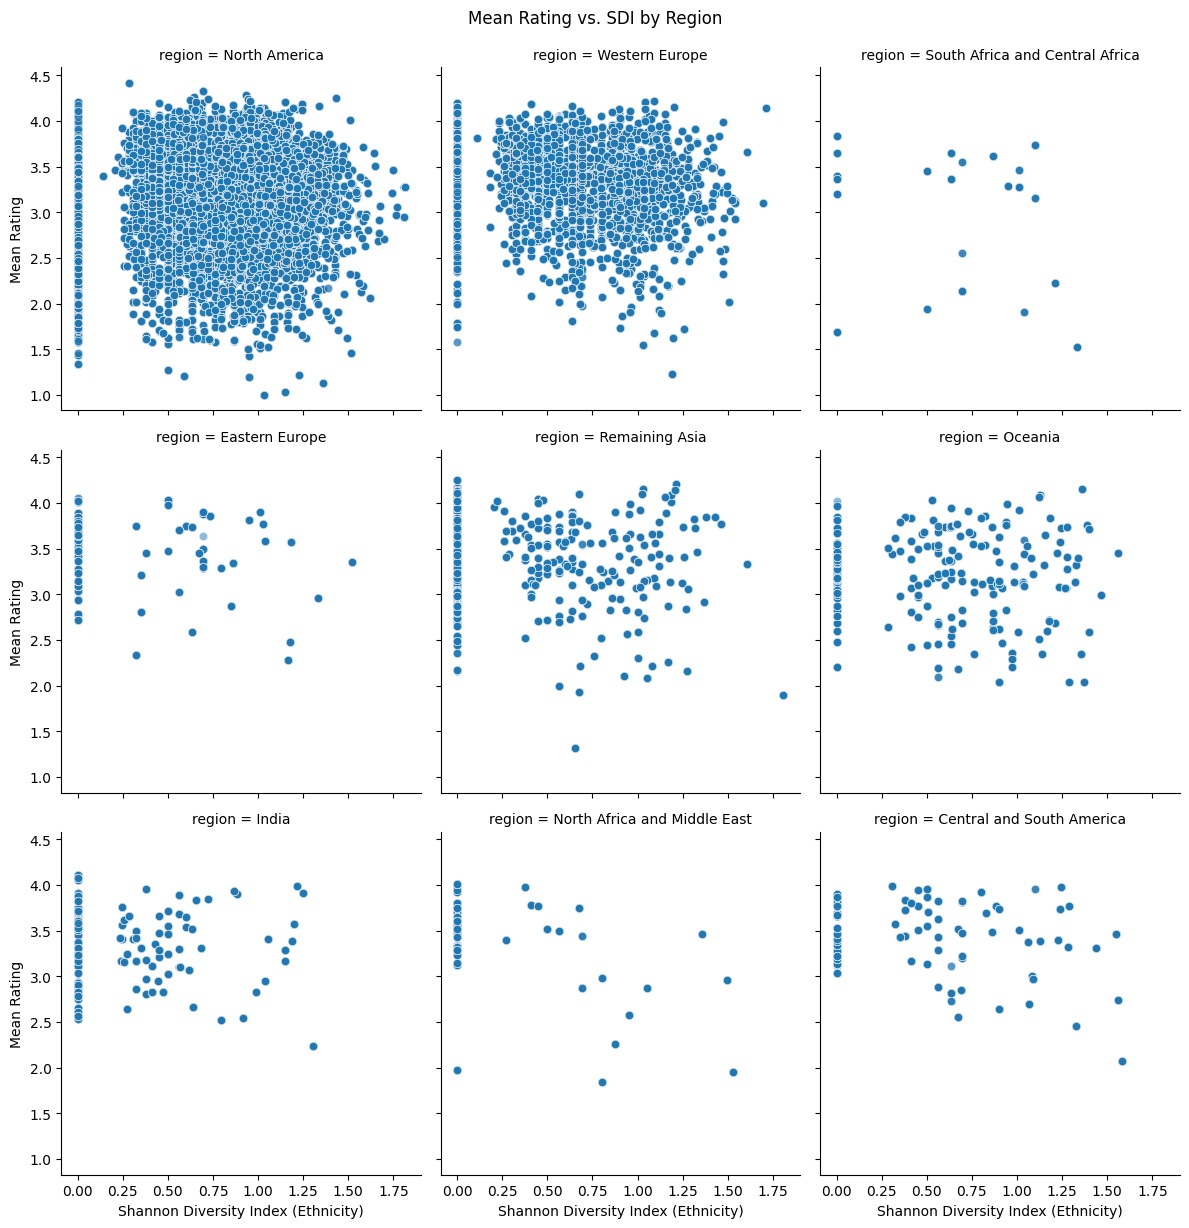

In [72]:

g = sns.FacetGrid(df_movies_tmdb_ratings_characters, col='region', col_wrap=3, height=4)
g.map(sns.scatterplot, 'SDI_ethnicity', 'mean_rating', alpha=0.5)
g.set_axis_labels('Shannon Diversity Index (Ethnicity)', 'Mean Rating')
g.fig.suptitle('Mean Rating vs. SDI by Region', y=1.02)
plt.show()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_22916/2840553467.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_region = df_binned.groupby(['region', 'SDI_bin'])['mean_rating'].mean().reset_index()


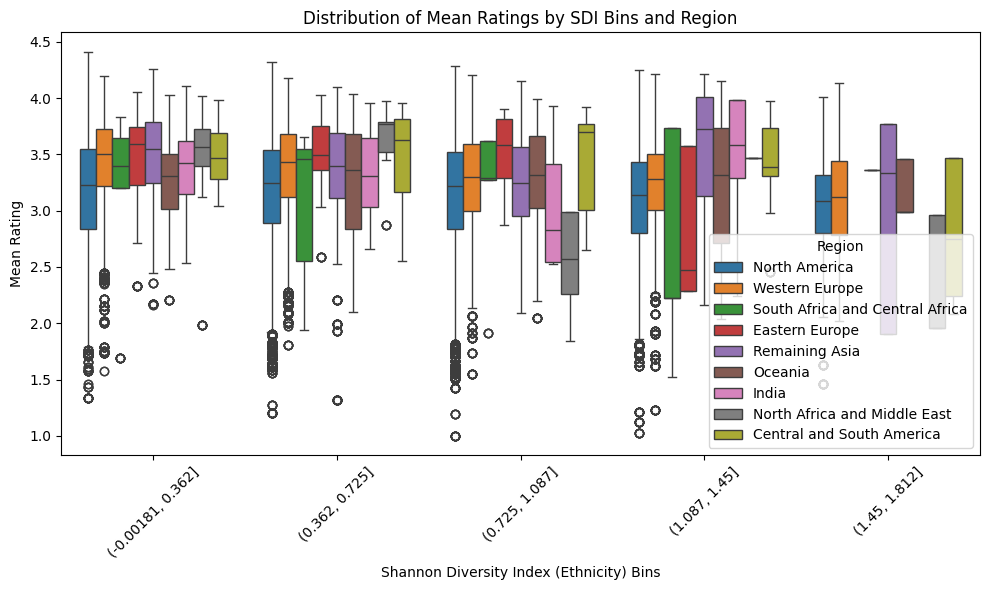

In [74]:
# Create bins for SDI
df_binned = df_movies_tmdb_ratings_characters.copy()
df_binned['SDI_bin'] = pd.cut(df_binned['SDI_ethnicity'], bins=5)

# Aggregate mean rating per bin per region
avg_by_region = df_binned.groupby(['region', 'SDI_bin'])['mean_rating'].mean().reset_index()

# Using the already binned df_binned
plt.figure(figsize=(10,6))
sns.boxplot(data=df_binned, x='SDI_bin', y='mean_rating', hue='region')
plt.title('Distribution of Mean Ratings by SDI Bins and Region')
plt.xlabel('Shannon Diversity Index (Ethnicity) Bins')
plt.ylabel('Mean Rating')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.show()




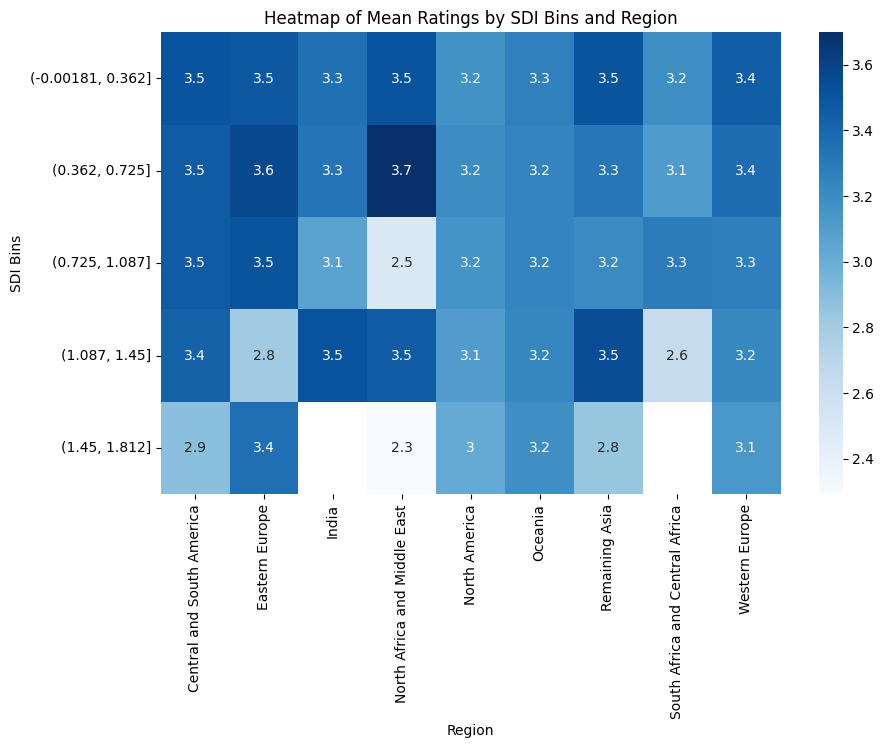

In [75]:
pivot = avg_by_region.pivot(index='SDI_bin', columns='region', values='mean_rating')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap='Blues')
plt.title('Heatmap of Mean Ratings by SDI Bins and Region')
plt.xlabel('Region')
plt.ylabel('SDI Bins')
plt.show()

In [65]:
df_movies_tmdb_ratings_characters.columns

Index(['wikipedia_id', 'actor_gender', 'ethnicity_label', 'actor_ethnicity',
       'freebase_actor_id', 'countries', 'title', 'release_date', 'genres',
       'mean_rating', 'mean_rating_timestamp', 'region', 'SDI_ethnicity',
       'SDI_gender'],
      dtype='object')

In [66]:
df_correlation_gender = df_movies_tmdb_ratings_characters[['mean_rating', 'SDI_gender']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_gender['mean_rating'], df_correlation_gender['SDI_gender'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_gender['mean_rating'], df_correlation_gender['SDI_gender'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.0700, p-value: 0.0000
Spearman correlation: -0.0480, p-value: 0.0000


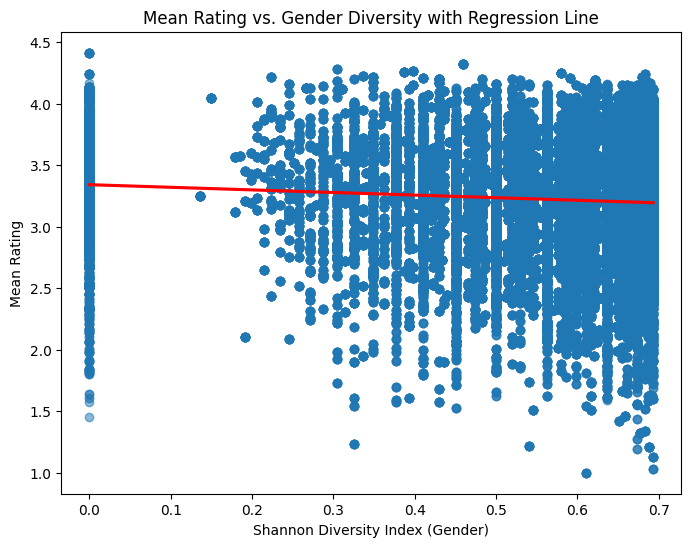

In [67]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_gender', 
    y='mean_rating', 
    data=df_correlation_gender, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()

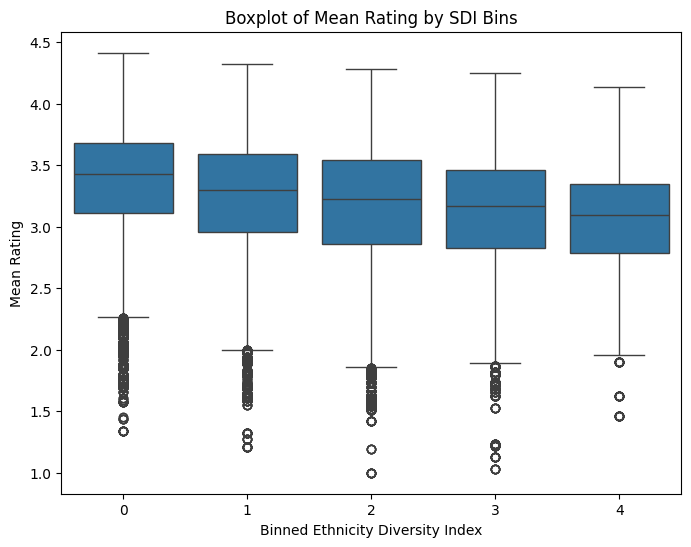

In [68]:
# Example: create bins for SDI_ethnicity
df_binned = df_correlation_ethnicity.copy()
df_binned['SDI_bin'] = pd.cut(df_binned['SDI_ethnicity'], bins=5, labels=False)

plt.figure(figsize=(8,6))
sns.boxplot(x='SDI_bin', y='mean_rating', data=df_binned)
plt.xlabel('Binned Ethnicity Diversity Index')
plt.ylabel('Mean Rating')
plt.title('Boxplot of Mean Rating by SDI Bins')
plt.show()